In [3]:
import os
import cv2
import numpy as np
import math
import sys

import matplotlib.pyplot as plt
%matplotlib inline

In [9]:

def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

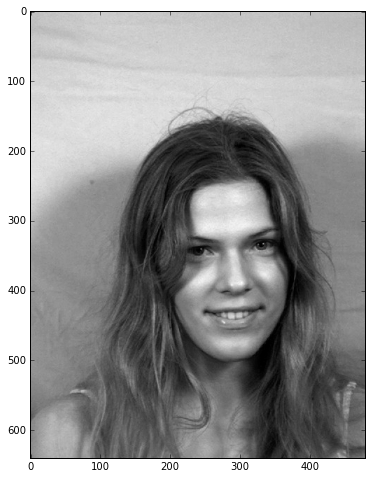

In [136]:
img = cv2.imread('figs/front-image.jpg')

img_gray = rgb2gray(img)

plt.figure(figsize=(6,8))
plt.imshow(img_gray, cmap = plt.get_cmap('gray')) #cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.show()

In [41]:
import pandas 

# opencv coordinates: origin 0,0 is at top left corner
df = pandas.read_csv('muct76-opencv.csv', header=0, usecols=np.arange(2,154), dtype=float)

X = df.iloc[:, ::2].values
Y = df.iloc[:, 1::2].values

print(X.shape, Y.shape)

df.head()

(7510, 76) (7510, 76)


,x00,y00,x01,y01,x02,y02,x03,y03,x04,y04,...,x71,y71,x72,y72,x73,y73,x74,y74,x75,y75
0,201.0,348.0,201.0,381.0,202.0,408.0,209.0,435.0,224.0,461.0,...,235.5,348.5,338.0,333.5,324.0,335.5,326.0,342.5,340.0,340.5
1,162.0,357.0,157.0,387.0,160.0,418.0,167.0,446.0,182.0,477.0,...,202.5,359.0,305.5,346.0,291.5,348.0,292.0,354.5,306.0,352.5
2,212.0,352.0,203.0,380.0,200.0,407.0,211.0,439.0,224.0,479.0,...,257.5,355.0,344.5,343.5,334.0,345.0,335.0,351.0,345.5,349.5
3,157.0,316.0,155.0,348.0,154.0,373.0,159.0,407.0,172.0,435.0,...,192.0,319.0,295.5,311.5,280.0,313.0,282.0,320.0,297.5,318.5
4,201.0,373.0,200.0,408.0,203.0,433.0,213.0,463.0,226.0,481.0,...,237.0,377.5,335.5,366.5,322.0,369.0,324.5,375.0,338.0,372.5


/home/vahid/.virtualenvs/cv/lib/python3.4/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


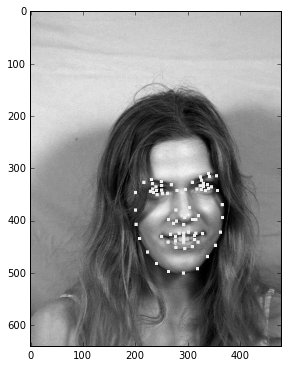

In [52]:
img_gray = rgb2gray(img)

for x, y in zip(X[0,:], Y[0,:]):
    img_gray[y-3:y+3, x-3:x+3] = 140

plt.figure(figsize=(8,6))
plt.imshow(img_gray, cmap = plt.get_cmap('gray')) #cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.show()

## Delauny Triangulation

(80, 2)


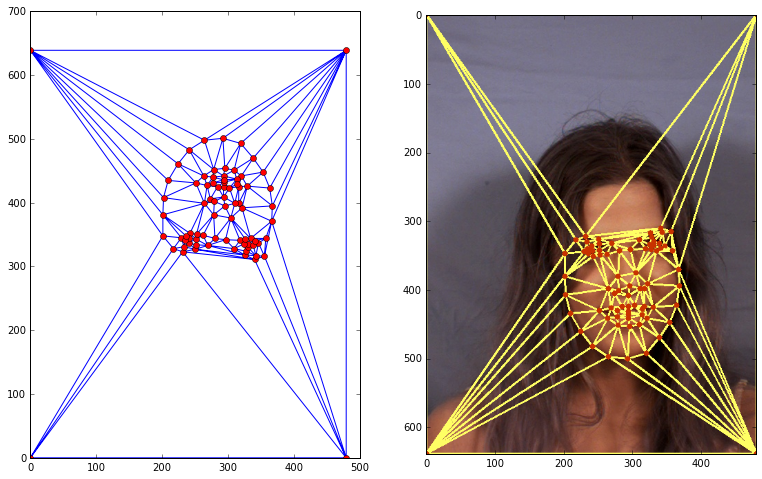

In [137]:
import scipy.spatial

points = np.array([[0, 0], 
                   [img.shape[1]-1,0], 
                   [0, img.shape[0]-1], 
                   [img.shape[1]-1, img.shape[0]-1]])


points = np.concatenate((points, np.vstack ((X[0,:], Y[0,:])).T))
print(points.shape)

tri = scipy.spatial.Delaunay(points)

plt.figure(figsize=(13,8))
plt.subplot(1, 2, 1)
plt.triplot(points[:,0], points[:,1], tri.simplices.copy())
plt.plot(points[:,0], points[:,1], 'o')

plt.subplot(1, 2, 2)
points = points.astype(int)
for i,j,k in tri.simplices:
    cv2.line(img, tuple(points[i,:]), tuple(points[j,:]), color=(100,255,255), thickness=2)
    cv2.line(img, tuple(points[i,:]), tuple(points[k,:]), color=(100,255,255), thickness=2)
    cv2.line(img, tuple(points[j,:]), tuple(points[k,:]), color=(100,255,255), thickness=2)
    cv2.circle(img, tuple(points[i,:]), 4, color=(0,50,200), thickness=-1)
    cv2.circle(img, tuple(points[j,:]), 4, color=(0,50,200), thickness=-1)
    cv2.circle(img, tuple(points[k,:]), 4, color=(0,50,200), thickness=-1)
    
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

plt.show()

In [153]:
meanface = np.load('models/meanshape.pkl')
Phi_matrix = np.load('models/eigenvectors.pkl')[:,:2]
eig_values = np.load('models/eigenvalues.pkl')

print(meanface.shape)
print(Phi_matrix.shape)
print(eig_values.shape)

(152,)
(152, 2)
(152,)


(76, 2)
(76, 2)
(76, 2)
(76, 2)


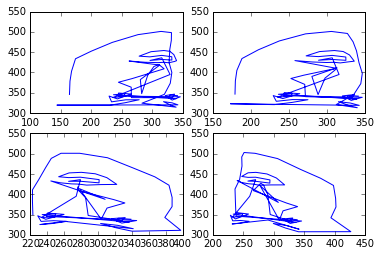

In [164]:
def construct_newface(origface, Phi_matrix, b):
    print(origface.shape)
    face = origface.flatten('F') + np.dot(Phi_matrix, b )
    
    return (face[:76], face[76:])


b = np.zeros(shape=2)
for i,j in enumerate((-0.025, -0.015, 0.015, 0.025)):
    b[0] = j*eig_values[0]
    newface_x, newface_y = construct_newface(points[4:,:], Phi_matrix, b)
    plt.subplot(2, 2, i+1)
    plt.plot(newface_x, newface_y)
    
plt.show()

In [170]:
# Find bounding box. 
origface = points[4:,:]
newface = np.vstack((newface_x, newface_y)).T.astype(int)

for indx in tri.simplices[0:2,:]:
    tcoors1 = origface[indx, :]
    r1 = cv2.boundingRect(tcoors)
    tcoors2 = newface[indx, :]
    print(tcoors1)
    print(tcoors2)


[[201 381]
 [233 331]
 [201 348]]
[[236 383]
 [232 334]
 [237 350]]
[[353 448]
 [209 435]
 [202 408]]
[[376 439]
 [243 436]
 [236 412]]


In [111]:
points

array([[  0,   0],
       [474,   0],
       [  0, 634],
       [474, 634],
       [201, 348],
       [201, 381],
       [202, 408],
       [209, 435],
       [224, 461],
       [241, 483],
       [264, 498],
       [292, 501],
       [319, 493],
       [338, 470],
       [353, 448],
       [363, 423],
       [367, 395],
       [366, 371],
       [357, 344],
       [355, 316],
       [340, 311],
       [325, 318],
       [309, 328],
       [327, 324],
       [342, 317],
       [217, 328],
       [231, 323],
       [250, 327],
       [269, 333],
       [251, 334],
       [233, 331],
       [229, 345],
       [240, 337],
       [262, 349],
       [242, 352],
       [241, 344],
       [346, 337],
       [330, 330],
       [318, 341],
       [334, 344],
       [330, 336],
       [280, 344],
       [278, 381],
       [264, 399],
       [273, 406],
       [293, 409],
       [316, 399],
       [321, 392],
       [304, 376],
       [296, 342],
       [279, 402],
       [310, 399],
       [251,